# 4. A Closer Look on Discretize(Mesh)
Tuesday, November 6th, 2018<br>
Felicia Nurindrawati

In [2]:
from SimPEG import Mesh
import discretize
import numpy as np

The Mesh package is included in the discretize library inside of SimPEG. You can look at the source code here: <br>
    https://github.com/simpeg/discretize/tree/master/discretize

**discretize** contains the following packages (with links for their guide in the SimPEG website): <br>
Mesh-building Classes :<br>
- [**CurvilinearMesh**](http://docs.simpeg.xyz/content/api_core/api_MeshCode.html?highlight=curvilinear#discretize.CurvilinearMesh): Creates curvilinear mesh
- [**TensorMesh**](http://docs.simpeg.xyz/content/api_core/api_MeshCode.html#): Combines meshes from multiple axis into one grid
- [**CylMesh**](http://docs.simpeg.xyz/content/api_core/api_MeshCode.html#cylindrical-mesh): Mesh class for cylindrical problems
- [**TreeMesh**](http://docs.simpeg.xyz/content/api_core/api_MeshCode.html#tree-mesh): Creates a tree mesh
- [**BaseMesh**](http://docs.simpeg.xyz/content/api_core/api_Mesh.html?highlight=basemesh#discretize.BaseMesh.BaseMesh): Counts the meshes

Mesh-helper Classes: <br>
- **DiffOperators**
- **InnerProducts**
- **MeshIO**
- **Tests**


First, let us take a look at the different Mesh-building packages contained in SimPEG: <br>

## 1. CurvilinearMesh
src:https://github.com/simpeg/discretize/blob/master/discretize/CurvilinearMesh.py

As the name suggests, this class creates a curvilinear mesh such as the following: <br>
It needs the following properties to create the mesh: <br>
- **Nodes**: You should pass this as an input. The input of the class is contained in this property. Your input should be a list of array describing the node location. The shape of that list should account for either 2D or 3D (so the input length cannot be less than 2 or bigger than 3). This node will then be stored in a private variable as vectors.<br><br>
Here are the methods that are contained in the class: <br>

- **Check_Nodes**: It checks if the input are valid or not. 
- **gridCC**: Cell-centered grid. This method is used to create the grid location to be cell-centered.
- **gridN**: Nodal grid. This method is used to have the grid location to be in the "edge" or by the nodes. <br>
Fun Fact: The gridN source code had someone deleting a line of code, so I don't know if this is actually working or not. 
```python
if getattr(self, '_gridN', None) is None:
            raise Exception("Someone deleted this. I blame you.")
        return self._gridN
```
- **GridFx**: Face staggered grid in the x-direction. Apparently staggered grids refer to some kind of discretization for finite-difference problems, where the values are stored in cell centers of a specific plane, so in this case in X-plane. I'm not too familiar with this, but **GridFy** and **GridFz** also exists. 
- **GridEx**: Edge staggered grid in the x-direction. Should also be related to finite-difference problem. I'm not too familiar with this, but **GridEy** and **GridEz** also exists. 



The geometry for the cells in this Mesh can be visualized as such: <br>
![image](https://i.imgur.com/I38sw3F.png)

Likewise, there are a some geometry method that helps build the mesh inside the class: <br>
- **vol**: Construct cell volumes of the 3D model as 1D array. To do this, the method slices a cell into 5 tetrahedrons and sum them together. The method also slice them into a different set of 5 tetrahedrons and average the two volumes together to get the volume of the cell.  
- **area**: Compute areas of the cell's faces. Seems like it only calculates the area of 3 faces and use that to infer the other faces. 
- **normals**: Computes the face normals, which averages the computed normals so there would only be one normal per face (basically normal vector of a plane)
- **edge**: Deals with edge length in the cell


The following is an example on how to implement the CurvilinearMesh: <br>

X,Y: 0.0 0.0
X,Y: 0.0 0.3333333333333333
X,Y: 0.3333333333333333 0.0
X,Y: 0.37738295660074733 0.2892837100659193
...


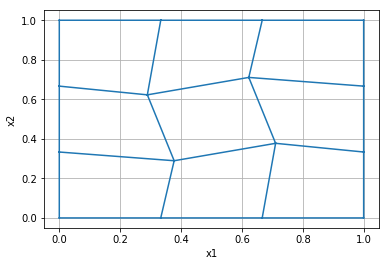

Accesible Properties:
volume: [0.11111111 0.10917074 0.11111111]
area: [0.33333333 0.29261824 0.37994508]
edge: [0.33333333 0.33333333 0.33333333]
normals: [[ 1.         -0.        ]
 [ 0.98860451 -0.15053615]
 [ 0.99325659 -0.11593682]]
Nodes, gridCC, gridN, gridFx, gridEx are also accessible


In [3]:

import discretize

X, Y = discretize.utils.exampleLrmGrid([3,3],'rotate') #Create a random 3x3 array

for i in range(0,2):
    for j in range(0,2):
        print("X,Y:", X[i,j], Y[i,j])
print("...")
M = discretize.CurvilinearMesh([X, Y])
M.plotGrid(showIt=True)
print("Accesible Properties:")
print("volume:", M.vol[:3])
print("area:", M.area[:3])
print("edge:", M.edge[:3])
print("normals:", M.normals[:3])
print("Nodes, gridCC, gridN, gridFx, gridEx are also accessible")

As you can see the above, the X, Y values that contains the location of the nodes in the 2D plane is well represented in the above plot. 

## 2. TensorMesh
src:https://github.com/simpeg/discretize/blob/master/discretize/TensorMesh.py

This class deals with tensor product of meshes. According to the source code in github, the **TensorMesh** class does the following:<br>

*<center>"TensorMesh is a mesh class that deals with tensor product meshes" </center>*<br>
The function accepts 'h', which is a width vector that lets you create these meshes. There are several ways to create these tensorMesh:<br><br>
**a. Using Array of Tuples**: <br>


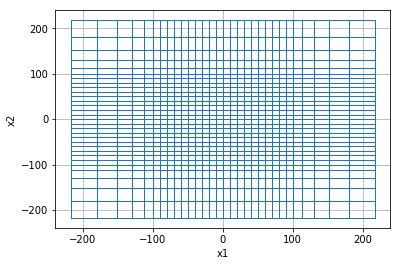

In [4]:
h = [(10,5,-1.3), (10,20), (10,5,1.3)]
mesh = Mesh.TensorMesh([h,h], 'CC')
mesh.plotGrid() #plotting the grid

This is what we used for the Gravity Example. This will accept the width vector 'h' as non-constant and changes as we go through each element in that vector. For example, if we have something like this: <br>
<center>$h = [(10,5,-1.3), (5, 20), (10,5,1.3)] $</center> <br>
That means in the this axis, you will be having 5+20+5 lines (second element for each tuple). The first tuple, (10,5,-1.3), means that each line in the mesh, you will have the following distance between lines for every iteration. <br>
<center>$-(10*1.3^1$),$-(10*1.3^2$), ..., $-(10*1.3^5$)  </center><br>
The second tuple will have 20 lines with a constant distance of 5. So you should be getting something like this:<br>
<center>$5*1^1,5*1^2, ..., 5*1^{20}$  </center><br>
Lastly, the third tuple would be the same as the first one. But because the exponential element is not negative, we should be seeing something like a "flipped version of the first tuple: <br>
<center>$10*1.3^1$,$10*1.3^2$, ..., $10*1.3^5$ </center><br>
Combining all of those together, we should get something like this:<br>

**b. Quick TensorMesh**<br>



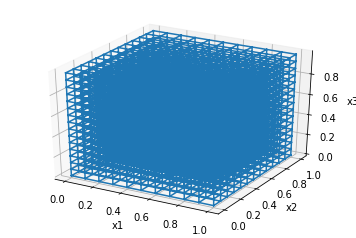

In [5]:
h = [10,12,15]
mesh = Mesh.TensorMesh(h)
mesh.plotGrid()

This is a quick way of creating a 3D unit cube. Inputting a [a,b,c] array will breate a mesh on a axbxc unit cube. For example, if you have something like: <br>
``` python 
mesh = Mesh.TensorMesh([10,12,15])
```
**Note**: Remember! In Mesh, count the *cubes*(white space), not the *lines*!

There is also input that you would put in the end of the function as the following:<br>
```python
mesh = Mesh.TensorMesh([h1,h2], 'CC')
```
The *'CC'* means **'Cell-Centered Grid'**. That means everything is centered at 0. This is the default state of the input.<br><br>
Another option for this is 'N', which means **Nodal Grid**, so everything would be to the left of zero. For example: <br>
    

Keep in mind that the number of 'C's and 'N's depends on the dimension of our mesh. If we're dealing with a 3D grid, that means it should be *'CCC'* and *'NNN'*, etc. <br>


**Parameters:**<br>
When you print your mesh, you will get something like this:<br>

In [6]:
print(mesh)

  ---- 3-D TensorMesh ----  
   x0: 0.00
   y0: 0.00
   z0: 0.00
  nCx: 10
  nCy: 12
  nCz: 15
   hx: 10*0.10,
   hy: 12*0.08,
   hz: 15*0.07,


Each of the parameters are defined as the following: <br>
- **x0**: First element location in our x-axis
- **nCx**: Number of elements in our x-axis
- **hx**: Each length for our cube in our mesh in the x-axis (width of cell)
- **vectorNx**: Vector of each location of the lines for our mesh in the x-axis (has N+1 elements, where N is the number of cubes in our grid in the x-axis)
- **vectorCCx**: Vector of each cell-centered location of the cube in the x-axis
- **gridCC**: Cell centered grid location (has NxN elements)
- **gridN**: Nodal grid location (has N+1 x N+1 elements)<br>
- **h_gridded**: Returns an array with widths of all cells but in order

(The above 'x's can be replaced by 'y' and 'z' to get the components in the respective axis)<br>
There are other parameters such as **gridFx**(face staggered grid), **gridEx**(Edge Staggered grid), but I have no idea what that means

**Classes**:<br>
The Tensormesh package have two main classes. Let's take a closer look on it: <br>

### BaseTensorMesh
This class has one property which is h, and as mentioned before, h is a list containing the cell widths of the tensor mesh in each dimension. It also accepts x0 as the origin, with default set to 0. It also makes sure that you have input the right format of h, otherwise it will give you a warning. Apparently it also deals with negative values. The parameters for this class is listed above

- **GetTensor**<br>
One of the method that is contained in this class is the *getTensor* method. This returns a tensor list that make up the geometry of the mesh. This can be viewed using these inputs: <br><br>
    *'CC'*: scalar field in cell centers<br>
    *'N'*: scalar field on the nodes<br>
    *'Fx'*: x-component of field defined on faces<br>
    *'Ex'*: x-component of field defined on edges<br><br>
Likewise, for Fx and Ex, there exist a y and z component for this input. Below is an example of how to access the getTensor method

In [7]:
mesh.getTensor('N')

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
        0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
        0.83333333, 0.91666667, 1.        ]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ])]

- **isInside**<br>
Determines if a set of points are inside a mesh. This method accepts the location of the points for the test and returns an array of booleans.
- **getInterpolationMat**<br>
Produces an interpolation matrix. This method accepts the location type of what your interpolation is going to be (refer to GetTensor's documentation for the set of input). Additionally, we can get the location type as *CCVx* which represents x-component of a vector defined on cell centers. <br><br>
Moreover, the class also contains a couple of private methods that deal with fast inner product of faces. However, it doesn't seem like it's interracting with any other function. Will be explained once we see a use for it. 

### TensorMesh
This class just basically calls the BaseTensorMesh class. It also deals with printing values and accounts for if the mesh is 1D, 2D, or 3D. <br>
The package also has Geometry properties, but it doesn't seem to have anything different from what was described in the *CurviLinear* package. The following are the geometry properties that is publically accessible: <br>

- **vol**: cell volumes of 3D model as 1D arrays
- **areaFx**: area of the x-faces
- **area**: face areas of the 3D model as 1D arrays 
- **edgeEx**: x-edge lengths
- **edge**: edge lengths of the 3D model as 1D arrays
- **FaceBoundaryInd**: find indices boundary faces in each direction (will be True if it is a boundary)
- **CellBoundaryind**: find indices boundary cells in each direction (will be True if it is a boundary)

Below is an example of how to access these geometries:

In [8]:
[a,b,c,d,e,f] = mesh.cellBoundaryInd
mesh.area

array([0.00555556, 0.00555556, 0.00555556, ..., 0.00833333, 0.00833333,
       0.00833333])

## 3. CylMesh
src:https://github.com/simpeg/discretize/blob/master/discretize/CylMesh.py


CylMesh stands for "cylindrical mesh" and as the name suggests, it deals with cylindrical problems. For cylindrically symmetric meshes, use **[hx,1,hz]**.<br>
Each unit's dimension is: [1, $2\pi$, 1]<br>
This is a really complicated library @.@ <br>
In essence, it works the same as TensorMesh, but with added features, such as the location validation checking for radius too. There are also _ishanging_ functions that I'm not sure what its doing. Furthermore, it uses a lot of _np.kron_. Though it seems to be the kronnecker product, I don't how exactly is this relevant to mesh building.  Hopefully we don't need to deal with Cylindrical Mesh 

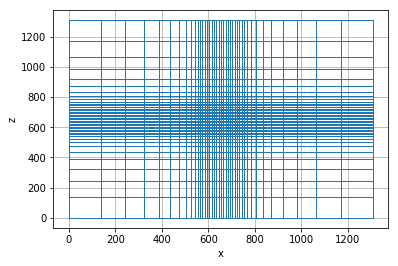

In [76]:
from SimPEG import Utils
cs, nc, npad = 10., 20, 10
hx = Utils.meshTensor([(cs,npad,-1.3), (cs,nc), (cs,npad,1.3)])
hz = Utils.meshTensor([(cs,npad,-1.3), (cs,nc), (cs,npad,1.3)])
mesh = Mesh.CylMesh([hx,1,hz])
mesh.plotGrid(showIt=True)



From above, we see a similar format of inputting the array into the mesh as the one we see in TensorMesh. We see that in the x-axis, you have 19 cells, that's npad+nc+npad. However, as you increase npad, you get a tighter mesh in the middle of the z-axis and x-axis. Unlike in TensorMesh, the tupple containing two values does not mean constant-width mesh. Rather, it has a somewhat cyclical pattern to it (?). 

## 4. TreeMesh
src:https://github.com/simpeg/discretize/blob/master/discretize/TreeMesh.py


The documentation for this module starts with an ascii art of the mesh's geometry. I've created a visualization of that as the following: <br>
![image](https://i.imgur.com/YlY4Fvr.png)

Before delving into the module, I tried to search for what tree mesh looks like, and this is what I found: <br>
![image](https://numericalmethods.files.wordpress.com/2013/02/amr_asg.jpg)

The class actually inherits the parameters from BaseTensorMesh. And apparently it only accepts the cell width of the vector to be a power of 2. If not, the initializing function will yell at you. The properties in this class include: <br>
- **vntF**
- **vntE**
- **cellGradStencil**
- **cellGradx**: Cell centered Gradient operator in x-direction (GradX)
        Grad = sp.vstack((Gradx, Grady, Gradz))
- **faceDivx**: 
- **cellGrad**: Cell centered Gradient operator built off of the faceDiv operator.
        Grad =  - (Mf)^{-1} * Div * diag (volume)
        
![image](https://i.kym-cdn.com/photos/images/original/001/026/838/cc4.jpeg)

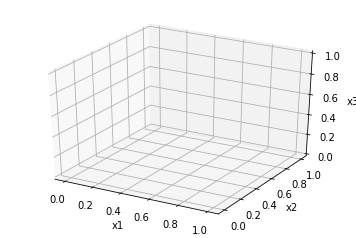

In [95]:
h1 = [(20,2),(12,2)]
h2 = [2,2,2,2,1,5,3,5]
mesh = Mesh.TreeMesh([h1,h1,h1])
mesh.plotGrid() #plotting the grid

## BaseMesh
src:https://github.com/simpeg/discretize/blob/master/discretize/BaseMesh.py<br>
This has inheritance from Utilities, but only from the mkvc method, which allows the creation of a vector with a certain dimension. This will be covered in depth in another chapter. <br>
According to the source code, BaseMesh does the counting of the cells for the other mesh-building classes. The following are its parameters: <br>
- **n (hidden)**: number of cells in each direction
- **x0**: origin of the mesh
- **dim**: dimension of the mesh
- **nC**: total number of cells in the mesh
- **nN**: total number of nodes in the mesh
- **nEx**: number of x-edges
- **vnE**: total number of edges in each direction (returns [nEx, nEy, nEz])
- **nE**: number of edges (returns sum of nEx, nEy, and nEz)
- **nFx**: number of x-faces
- **vnF**: total number of faces in each direction (return [nFx, nFy, nFz])
- **nF**: total number of faces (sum of vnF)
- **normals**: face normals 
- **tangents**: returns edge tangents

There are also several methods that can be called to check the validity of the mesh, such as: <br>
- **check_n_shape**: Checks if the dimensions are correct (can't be higher than 3 and lower than 1), or if the sizes agree with the input
- **check_x0**: checks if n is set before setting up x0
- **projectFaceVector**: With a vector in cartesian coordinate as an input, this will project it into the mesh using the normals
- **projectEdgeVector**: With a vector eV in cartesian coordinate as an input, this will project it into mesh using tangents

There is also the following class in the BaseMesh library: <br>
### BaseRectangularMesh
It basically has the same properties as above, but quickly asserts Nx, Ny, Nz as the three elements in our array. There are a few methods that are different in this case: <br>
- **r**: quick reshape command 
The documentation already explained it quite well.
```python
    mesh.r(V,'F','Fx','M')
    ```
In the above command, we have:
    - *V* as our input, which is a list
    - *'F'*(what is it) is the LocType (e.g. 'CC', 'N', etc)
    - *'Fx'*(what you want it to be) is the LocType  (e.g. 'CC', 'N', etc)
    - *'M'* (how) a matrix<br><br>
For example, if you want to separate each component of the Ex grid into 3 matrices: <br>



```python
Xex, Yex, Zex = mesh.r(mesh.gridEx, 'Ex', 'Ex', 'M')
```

Given an edge vector, return just the x edges as a vector
```python
XedgeVector = mesh.r(mesh.edge, 'E', 'Ex', 'V')
```
Separates each component of the edgeVector into 3 vectors
```python
eX, eY, eZ = mesh.r(mesh.edge, 'E', 'E', 'V')
```

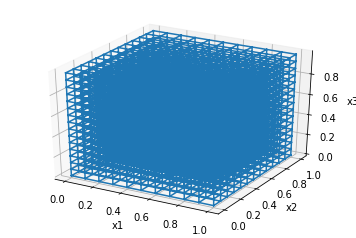

In [134]:
h = [10,12,15]
mesh = Mesh.TensorMesh(h)
mesh.plotGrid()
Xex, Yex, Zex = mesh.r(mesh.gridEx, 'Ex', 'Ex', 'M')
XedgeVector = mesh.r(mesh.edge, 'E', 'Ex', 'V')
eX, eY, eZ = mesh.r(mesh.edge, 'E', 'E', 'V')